### Parte 1: Importing Packages, Data, Helper Functions

In [2]:
#-------------------------------------------------------
# Importar paquetes a utilizar
#-------------------------------------------------------
import pandas as pd
import numpy as np 
import networkx as nx
import scipy.stats as stats
import numpy.linalg

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math


Reading and gathering of the graphs from the generated sets $\mathcal{S}_{j}$:

In [1]:
'''
#in this dictionary we collect the information for the 200 random graphs we generated
G={'Nuevas_Conexiones':[],'Numero_Respuestas':[], 'Rango_Respondientes':[], 'Respondientes':[]}

for key in G.keys():
    for i in range(200):
        G[key].append(nx.read_graphml('Synthetic_Graphs_Colab_Methodology/Random_Graphs_'+key+'/Random_Graph_'+key+str(i)+'.graphml'))
'''

"\n#in this dictionary we collect the information for the 200 random graphs we generated\nG={'Nuevas_Conexiones':[],'Numero_Respuestas':[], 'Rango_Respondientes':[], 'Respondientes':[]}\n\nfor key in G.keys():\n    for i in range(200):\n        G[key].append(nx.read_graphml('Synthetic_Graphs_Colab_Methodology/Random_Graphs_'+key+'/Random_Graph_'+key+str(i)+'.graphml'))\n"

In [4]:
#-------------------------------------------------------
# Functions for computing Graph Metrics
#-------------------------------------------------------


def central_point_dominance(G):
    '''
    How centralized a graph is with respect to the metric betweenness centrality.
    '''
    betwennesses = nx.betweenness_centrality(G)
    b_max = max(betwennesses.values())
    N = len(betwennesses.keys())
    count = 0
    for i, b_i in betwennesses.items():
        count += ( b_max - b_i )/(N-1)
    return count


def spectral_radius(G):
    '''
    Largest absolute value of an eigenvector of Adj(G). The smaller s.r. is, the higher the probability 
    of spread of viral phenomena. 
    '''
    L = nx.normalized_laplacian_matrix(G)
    e = numpy.linalg.eigvals(L.A)
    e_abs = [abs(x) for x in e]
    return max(e_abs)


def core_ratio(G):
    '''
    Portion of the graph G which is within 2-core of G
    '''
    return len(nx.k_core(G,k=2).nodes())/len(G.nodes())

def rich_club_coeffs(G):
    '''
    Function that returns a dictionary mapping each k to fraction of edges present amons k-core members of G. 
    '''
    t_ok = True
    t = 0
    d = dict()
    while t_ok:
        nodes_large_degree=[]
        for x in G.nodes():
            if G.degree(x)>t:
                nodes_large_degree.append(x)
        core = G.subgraph(nodes_large_degree)
        edges_core = len(core.edges())
        nodes_core = len(core.nodes())
        if nodes_core<=1:
            t_ok = False
            break
        d[t] = (2*edges_core)/(nodes_core*(nodes_core-1))
        t += 1 
    return d        

def max_rich_club(G):
    '''
    Returns maximum possible Rich Club Coefficient for G.
    '''
    rich_club=rich_club_coeffs(G)
    max_i=0
    for i in range(len(rich_club)):
        if rich_club[i]>rich_club[max_i]:
            max_i=i
        else:
            return rich_club[max_i]

def eccentricity(G):
    '''
    Finds average eccentricity for a node in G. 
    '''
    excentricidades=nx.algorithms.distance_measures.eccentricity(G)
    excentricidad=0
    for i in excentricidades.keys():
        excentricidad+=excentricidades[i]
    return excentricidad/len(excentricidades.keys())


def avg_responses(G):
    '''
    Computes average number of responses provided by nodes in a graph G generated through synthetic method. 
    '''
    avg, respondents = 0 , 0
    resp_dictionary = nx.get_node_attributes(G, 'responses')
    for node in G.nodes():
        try:
            avg += resp_dictionary[node]
            respondents += 1
        except:
            pass
    if respondents == 0:
        return 0
    return avg/respondents


def degree(G):
    '''
    Computes average degree of the nodes in a graph G.
    '''
    return 2*len(G.edges())/len(G.nodes())


def modularity(G):
    '''
    Computes through NetworkX's algorithm, the modularity of a graph G. 
    '''
    return nx.algorithms.community.quality.performance(G,nx.algorithms.community.modularity_max.greedy_modularity_communities(G))


def clustering(G):
    '''
    Computes average clustering coefficient among those nodes with degree at least 2. 
    '''
    total, count = 0, 0
    for v in G.nodes():
        if nx.degree(G,v) >= 2:          #solo el clustering coeff de nodos con deg>=2
            total += nx.clustering(G,v)
            count += 1
    return total/count

### Part 2: Creation of DataFrame

This section computes and forms an embedding with all graph metrics we will use to study all 800 synthetic graphs, and all 15 collaborativity metrics.

In [6]:
metric_function_map = {'Degree': degree,
            'Excentricidad': eccentricity,
            'Diametro': nx.diameter,
            'Radio':nx.radius,
            'Camino más corto promedio':nx.average_shortest_path_length,
            'Transitividad':nx.transitivity,
            'Eficiencia Global':nx.global_efficiency,
            'Rich Club Coefficient':max_rich_club,
            'Core Ratio':core_ratio,
            'Central Point Dominance':central_point_dominance,
            'Spectral radius':spectral_radius,
            'Modularidad':modularity,
            'Average Collaborations': avg_responses,
            'Clustering': clustering}

def measures(G):
    D = dict()
    for metric, function in metric_function_map.items():
        D[metric] = [function(nx.to_undirected(G))]
    return D

def embed(D1, D2):
    for key, value in D1.items():
        D2[key].append(value)
    return D2

def df_colaboraciones_test(keys,n=200):
    """
    Función que, para cada uno de los sets de 200 grafos sintéticos
    * computa todas las métricas de grafo
    * embede dichas métricas en un diccionario
    
    Inputs:
        keys    list    lista de aquellos atributos que variaron en los sets de grafos sinteticos
        n       int     numero de grafos con los que disponemos por cada aspecto en 'keys'
        
    Outputs: 
        diccionario que por cada aspecto en 'keys' almacena un DataFrame donde 
        las columnas son métricas de grafo, y hay una fila por grafo sintético.
    """

    dfs={}

    for key in keys:
        for index in range(n):
            graph=G[key][index]
            if index==0:
                dict_meas=measures(graph)
            new=measures(graph)
            for metric in metric_function_map.keys():
                dict_meas[metric]+=new[metric]

        dfs[key]=pd.DataFrame()
        for metric in metric_function_map.keys():
            dfs[key][metric]=dict_meas[metric]

    return dfs

In [7]:
#We write CSV files for each DataFrame corresponding to one of the variations in parameters

#df_colaboraciones_test(['Nuevas_Conexiones'])['Nuevas_Conexiones'].to_csv('Synthetic_Graphs_Colab_Methodology/Random_Nuevas_Conexiones.csv')
#df_colaboraciones_test(['Numero_Respuestas'])['Numero_Respuestas'].to_csv('Synthetic_Graphs_Colab_Methodology/Random_Numero_Respuestas.csv')
#df_colaboraciones_test(['Rango_Respondientes'])['Rango_Respondientes'].to_csv('Synthetic_Graphs_Colab_Methodology/Random_Rango_Respondientes.csv')
#df_colaboraciones_test(['Respondientes'])['Respondientes'].to_csv('Synthetic_Graphs_Colab_Methodology/Random_Respondientes.csv')

#The function df_colaboraciones_test takes a long time to run as it takes graph metrics for 100s of graphs; 
#this is why we collected such information in CSV files, which we saved and recollect below

dfs = dict()
dfs['Nuevas_Conexiones'] = pd.read_csv('Synthetic_Graphs_Colab_Methodology/Random_Nuevas_Conexiones.csv')
dfs['Numero_Respuestas'] = pd.read_csv('Synthetic_Graphs_Colab_Methodology/Random_Numero_Respuestas.csv')
dfs['Rango_Respondientes'] = pd.read_csv('Synthetic_Graphs_Colab_Methodology/Random_Rango_Respondientes.csv')
dfs['Respondientes'] = pd.read_csv('Synthetic_Graphs_Colab_Methodology/Random_Respondientes.csv')


### Part 3: PCA Analysis

In this section, Principal Component Analysis is done for each of the sets $\mathcal{S}_{j}$ of synthetic graphs.

In [8]:
#---------------------------------------------
# Preparing Analysis Tools
#---------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X={}
normalized={}
pca={}
prin_comp={}

for key in dfs.keys():
    X[key]=dfs[key].to_numpy()

    normalized[key]= StandardScaler().fit_transform(X[key])
    pca[key]=PCA(n_components=5)
    prin_comp[key]=pca[key].fit_transform(normalized[key])

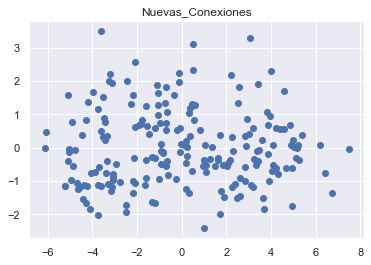

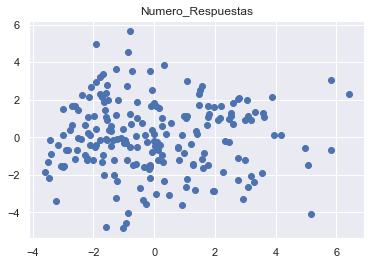

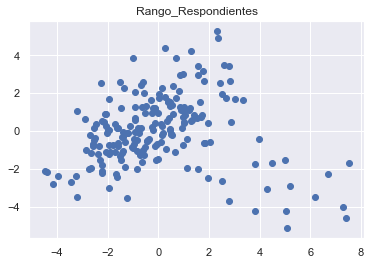

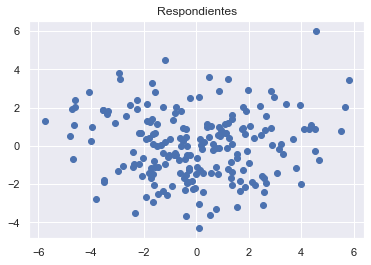

In [9]:
from matplotlib import pyplot as plt
for key in dfs.keys():
    f = plt.figure()
    plt.title(key)
    plt.scatter(prin_comp[key][:,0], prin_comp[key][:,1],color='b')

### Part 4: Collaborativity formulas

A total of 15 formulas are defined in this section. Each o them is potentially a metric that can help detect quantity and quality of collaboration. 

In [10]:
#---------------------------------------------
# Collaborativity Formulas
#---------------------------------------------

def colaborativity_formula_0(df):
    '''
    Original Collaborativity Formula during summer 2020 for project GED.
    Computes the colaborativity of a network G based on its measures, as shown below. 
    
    Input:
    - df : dataframe mapping each city to its graph metrics
    Returns:
    - Value describing the collaborativity of a graph, or network
    '''
    Avg_colabs =df['Average Collaborations']
    Clust = df['Clustering']
    Mod = df['Modularidad']
    return (1/2) * Avg_colabs * (Clust + (np.log10(Mod**2)*-1))


def colaborativity_formula_1(df):
    Efi = df['Eficiencia Global']
    Tran = df['Transitividad']
    Mod = df['Modularidad']
    Core = df['Core Ratio']
    return Efi + Tran + 1 - (Mod + Core)/2 


def colaborativity_formula_2(df):
    Efi = df['Eficiencia Global']
    Tran = df['Transitividad']
    Exc = df['Excentricidad']
    Mod = df['Modularidad']
    return Efi + Tran + (1/Exc) - Mod


def colaborativity_formula_3(df):
    efi = df['Eficiencia Global']   #comunicacion
    clus = df['Clustering']         #robustez
    mod = df['Modularidad']          #preparación para el futuro 
    return (efi * clus * (1+np.cos(math.pi*mod)) /2 )**(1/3)


def colaborativity_formula_4(df):
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    mod = df['Modularidad']           #preparación para el futuro 
    return (efi * tran * (1+np.cos(math.pi*mod)) /2 )**(1/3)


def colaborativity_formula_5(df):
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    core = df['Core Ratio']           #preparación para el futuro 
    return efi + tran + 1 - core 


def colaborativity_formula_6(df):
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    exc = df['Excentricidad']        #preparación para el futuro 
    return (efi * tran * (np.sin(math.pi/exc)) )**(1/3)


# N e w    i d e a s    f o r   f o r m u l a s #

def quadratic(L):
    L_squared = [x**2 for x in L]
    return (np.mean(L_squared))**0.5


def colaborativity_formula_7(df):
    Avg_colabs = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #2 calidad   comunicacion 
    tran = df['Transitividad']       #            robustez
    exc = df['Excentricidad']        #preparación para el futuro 
    #return 0.5*avg_deg  +  0.5*quadratic([efi , tran , (np.sin(math.pi/exc))])
    #return 0.5*avg_deg + 0.5*np.mean([efi , tran , (1/exc)])
    #return 0.5*(np.log10(avg_deg+1)/np.log10(26)) + 0.5*(efi + tran + (1/exc))*(1/3)
    return 0.5*(np.log(1+(Avg_colabs/25))) + 0.5*(1/3)*(efi + tran + (1/exc))


def colaborativity_formula_8(df):
    Avg_colabs = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #2 calidad   comunicacion 
    tran = df['Transitividad']       #            robustez
    mod = df['Modularidad']        #preparación para el futuro 
    #return 0.5*(np.log10(avg_deg+1)/np.log10(26)) + 0.5*(1/3)*(efi + tran + 0.5*(1+np.cos(math.pi*mod)))
    return 0.5*(np.log(1+(Avg_colabs/25))) + 0.5*(1/3)*(efi + tran + 0.5*(1+np.cos(math.pi*mod))) 


def colaborativity_formula_9(df):
    Avg_colabs = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #2 calidad   comunicacion 
    tran = df['Transitividad']       #            robustez
    rcc = df['Rich Club Coefficient']        #preparación para el futuro 
    core = df['Core Ratio']        #preparación para el futuro 
    exc = df['Excentricidad']    
    #return (1/4)*((avg_deg/25)**0.5 + efi + tran + rcc*core )
    return (1/4)*((Avg_colabs/25)**0.5 + efi + tran + (1/exc) )


def colaborativity_formula_10(df):
    Avg_colabs = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    exc = df['Excentricidad']        #preparación para el futuro 
    #return 0.5*(np.log10(avg_deg+1)/np.log10(26))+(efi * tran * (np.sin(math.pi/exc)) )**(1/3)
    return 0.5*(np.log(1+(Avg_colabs/25))) + (efi * tran * np.sin(math.pi/exc) )**(1/3)


def colaborativity_formula_11(df):
    Avg_colabs = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #2 calidad   comunicacion 
    tran = df['Transitividad']       #            robustez
    rcc = df['Rich Club Coefficient']        #preparación para el futuro 
    core = df['Core Ratio']        #preparación para el futuro 
    exc = df['Excentricidad']    
    return (1/4)*((Avg_colabs/25)**0.5 + efi + tran + (rcc*core/exc) )

# yet another one!
def colaborativity_formula_12(df):
    Avg_colabs = df['Average Collaborations']     #1 cantidad  
    efi = df['Eficiencia Global']                 #2 calidad   comunicacion 
    
    tran = df['Transitividad']                    #            robustez
    cpd = df['Central Point Dominance']
    
    exc = df['Excentricidad']                     #            preparación para el futuro 
    return (1/4)*(np.log(1+(Avg_colabs/25)) + efi + (tran*(1-cpd))**0.5 + (1/exc) )

def colaborativity_formula_13(df):
    Avg_colabs = df['Average Collaborations']     #1 cantidad  
    efi = df['Eficiencia Global']                 #2 calidad   comunicacion 
    tran = df['Transitividad']                    #            robustez
    cpd = df['Central Point Dominance']
    
    exc = df['Excentricidad']                     #            preparación para el futuro    
    
    return (1/4)*((Avg_colabs/25)**0.5 + efi + (tran*(1-cpd))**0.5 + (1/exc) )


def colaborativity_formula_14(df):
    Avg_colabs = df['Average Collaborations']     #1 cantidad  
    efi = df['Eficiencia Global']                 #2 calidad   comunicacion 
    tran = df['Transitividad']                    #            robustez
    cpd = df['Central Point Dominance']
    
    exc = df['Excentricidad']                     #            preparación para el futuro    
    
    rcc = df['Rich Club Coefficient']
    core = df['Core Ratio']
    return (1/4)*((Avg_colabs/25)**0.5 + (efi/exc)**0.5 + (tran*(1-cpd))**0.5 + (rcc*core) )

We compute collaborativity for each of the synthetic graphs, for each of the collborativity metrics $\mathcal{C}_{i}$.

Dataframe for Effectiveness of Colaborativity Formulas with respect to Parameter Variances.


/Users/olga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


,Nuevas_Conexiones,Numero_Respuestas,Rango_Respondientes,Respondientes
0,0.975,0.800,0.375,0.550
1,0.975,0.375,0.325,0.875
2,1.000,0.325,0.300,0.825
3,1.000,0.400,0.350,0.575
4,1.000,0.275,0.400,0.675
5,0.700,0.525,0.375,0.925
6,1.000,0.375,0.250,0.900
7,0.950,0.850,0.325,0.675
8,0.950,0.850,0.350,0.625
9,1.000,0.800,0.350,0.800


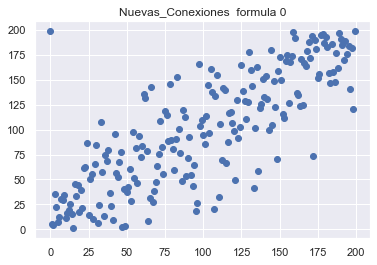

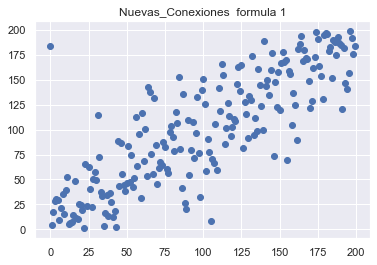

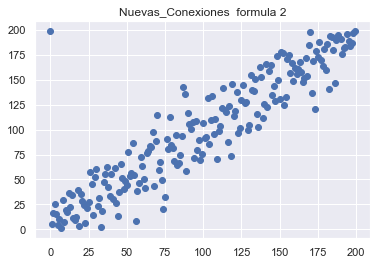

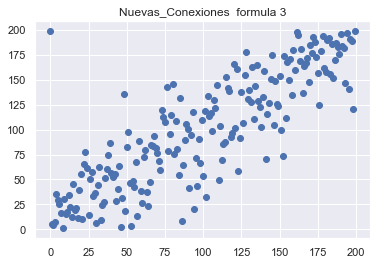

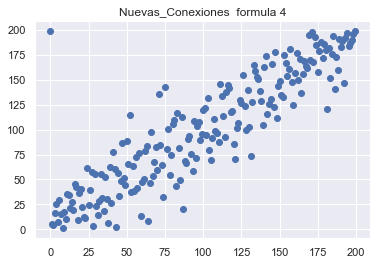

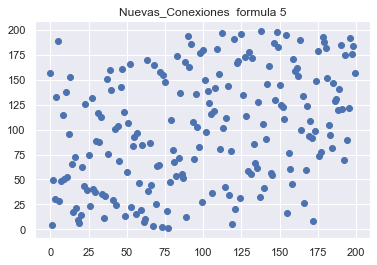

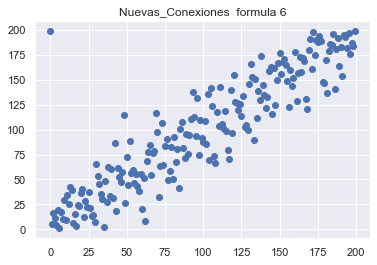

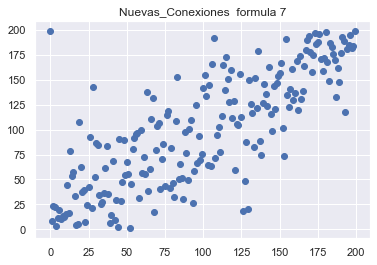

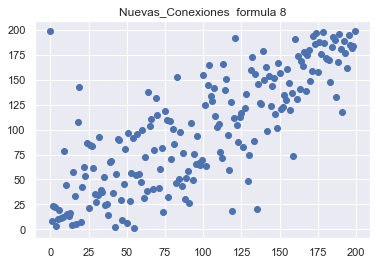

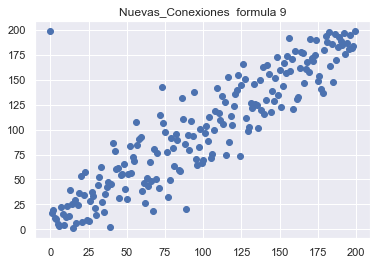

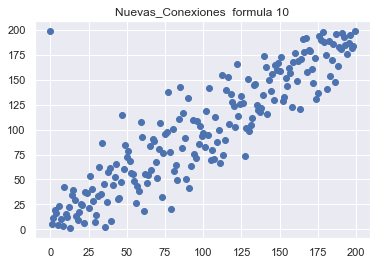

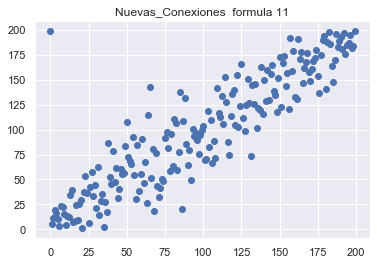

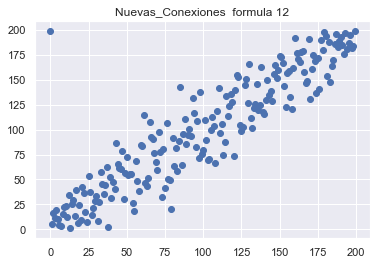

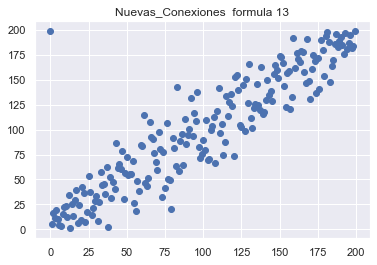

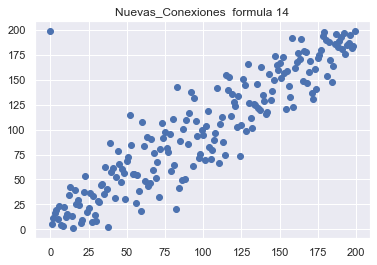

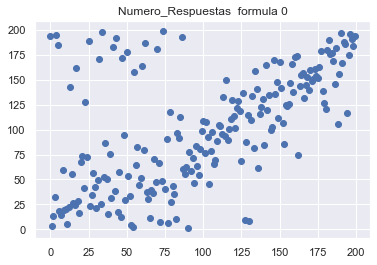

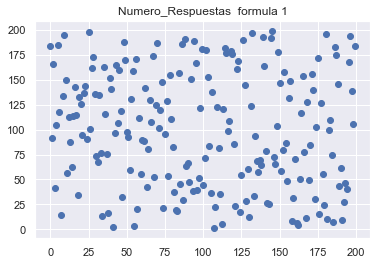

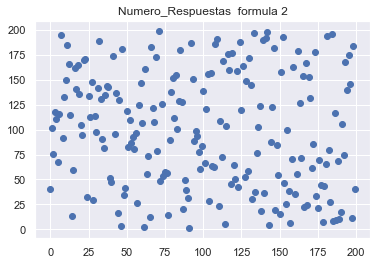

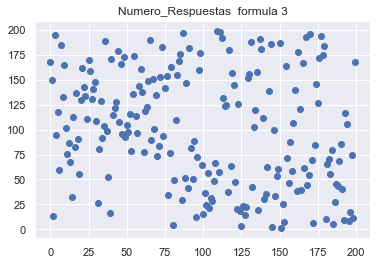

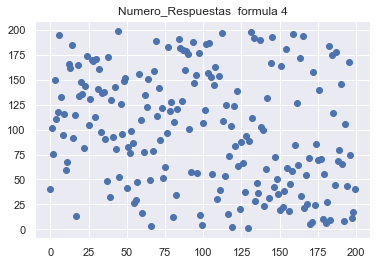

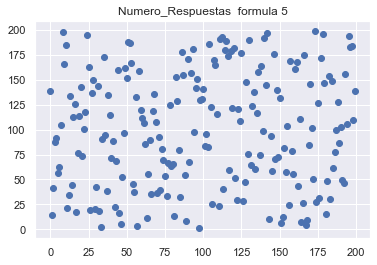

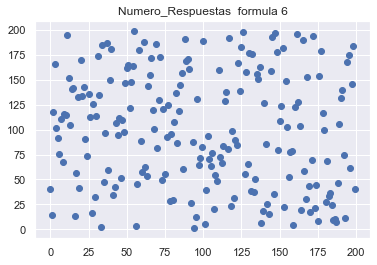

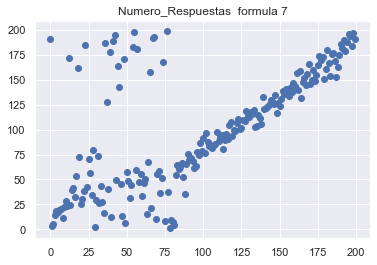

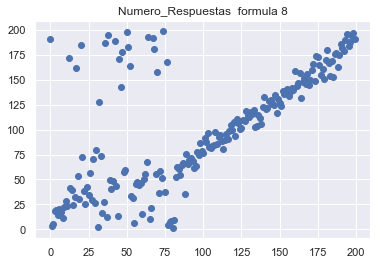

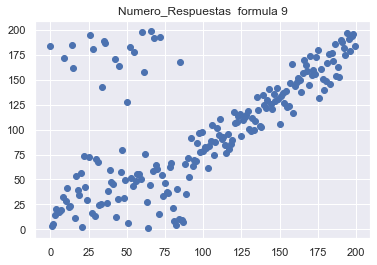

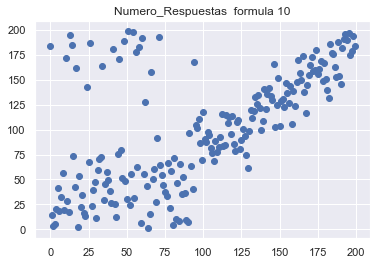

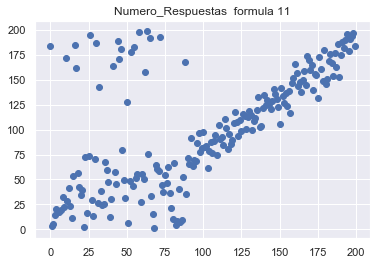

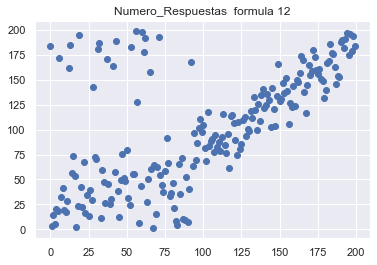

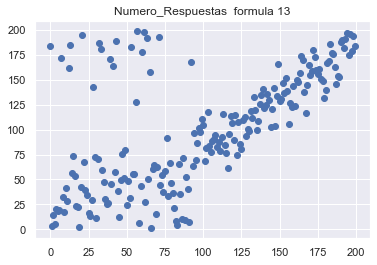

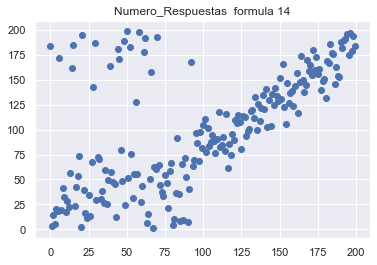

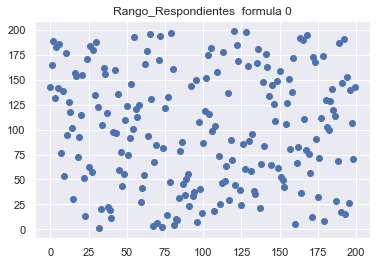

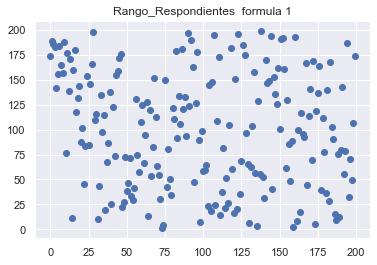

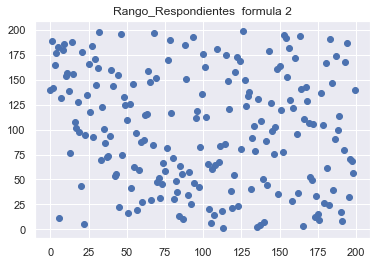

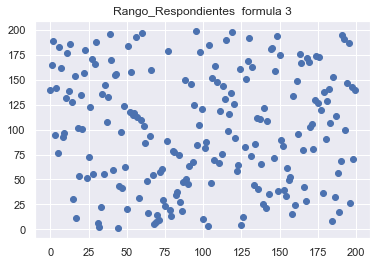

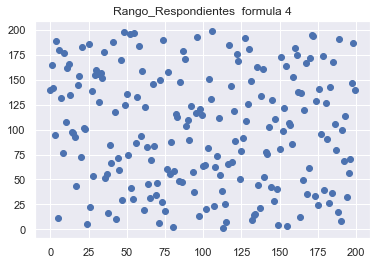

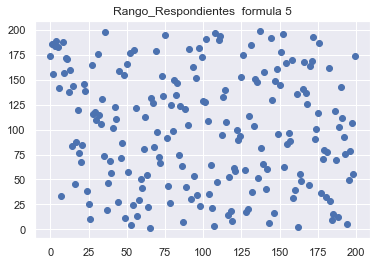

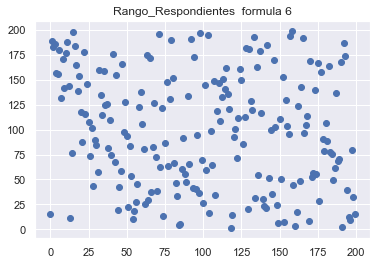

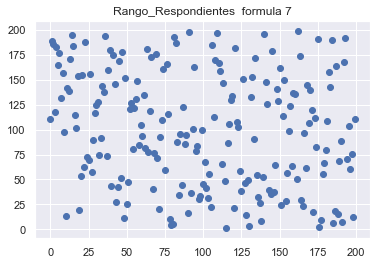

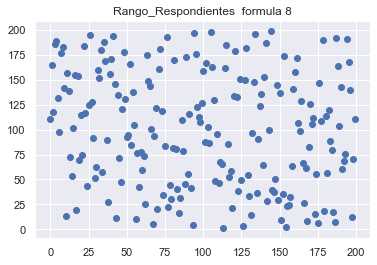

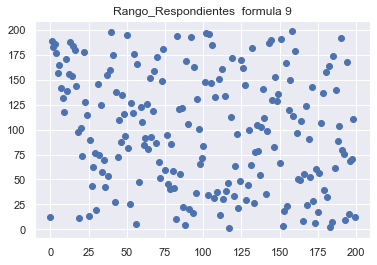

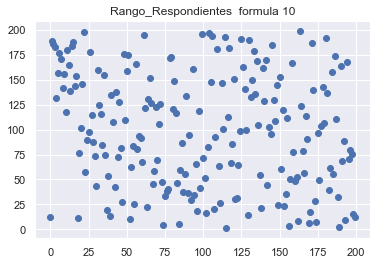

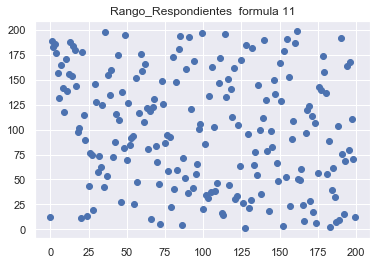

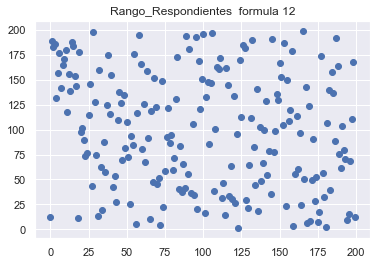

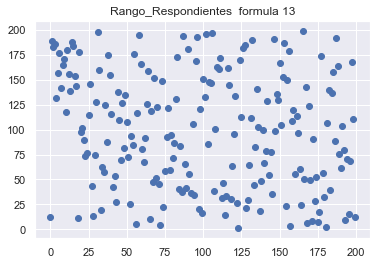

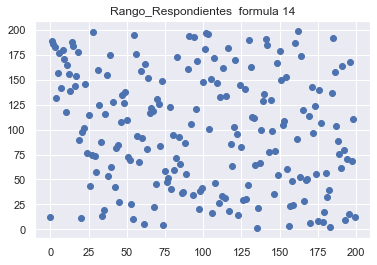

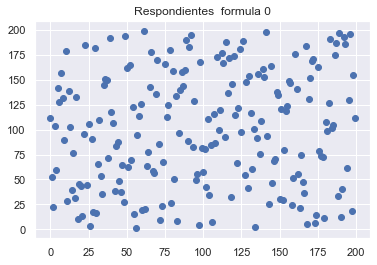

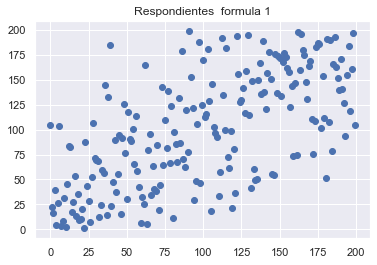

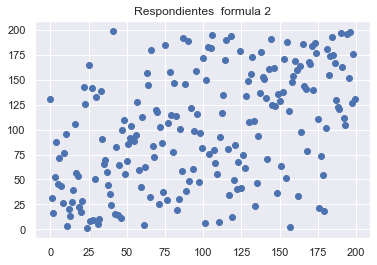

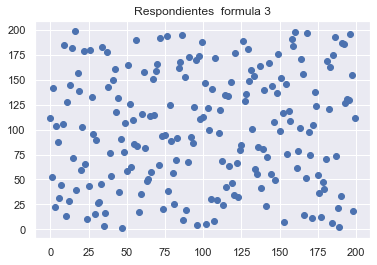

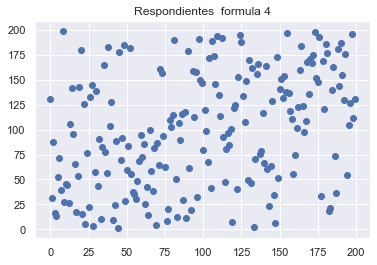

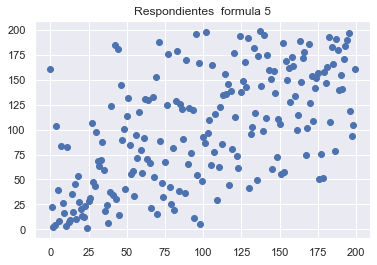

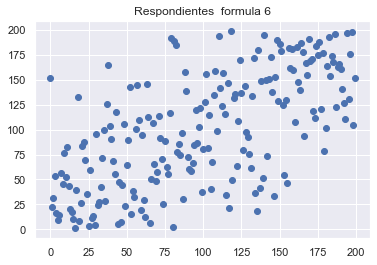

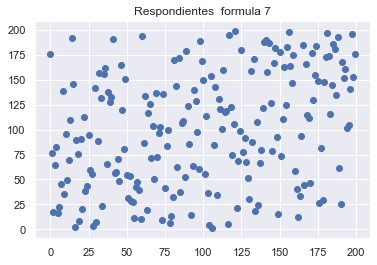

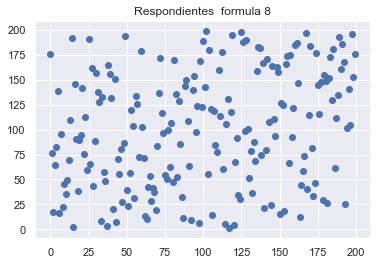

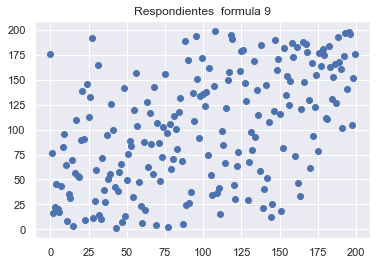

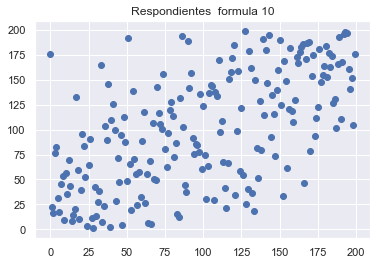

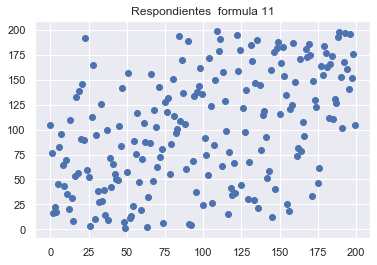

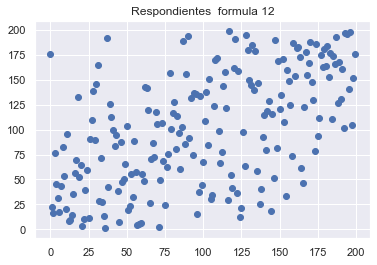

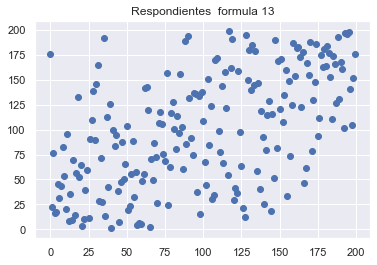

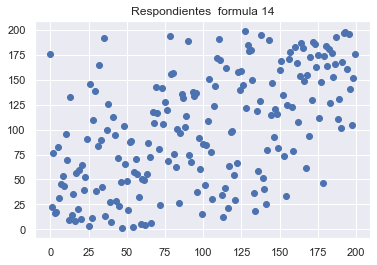

In [11]:
#-------------------------------------
# Effectiveness indices
#-------------------------------------
        # Effectiveness index: how many of the 40 graphs with highest collab_i are 
        # actually within 100 best graphs according to the construction?
        # a ver si puedo convertir esto en dataframe

colaborativity_formulas={}
for i in range(15):
    colaborativity_formulas[i]=eval('colaborativity_formula_'+str(i))
    
    
print('Dataframe for Effectiveness of Colaborativity Formulas with respect to Parameter Variances.')

eff_data = dict()
for key in dfs.keys():
    eff_data[key] = []
    for i in range(len(colaborativity_formulas)):
        colab={}
        colaboration_results = colaborativity_formulas[i](dfs[key])

        #key --> dict: graph_k--> collab_i(graph)
        
        colab[key] = {colaboration_results[x]:x for x in range(200)} 
        order_colab = list(colab[key].keys())
        order_colab.sort()
        ratio=0
        for j in range(40):
            if colab[key][order_colab[j]]<101:
                ratio += 1      
        eff_data[key].append(ratio/40)
        
                

        
        f = plt.figure()
        X = [ell for ell in range(200)]
        Y = [colab[key][order_colab[ell-1]] for ell in range(200)]
        plt.scatter(x=X, y=Y)
        plt.title(key+"  formula "+str(i))
        plt.savefig('Synthetic_Graphs_Colab_Methodology/Random_Graphs_'+key+'/'+key+'_Formula_'+str(i))

df = pd.DataFrame(eff_data)
df



### Part 5: Correlations between metrics and collaborativities

In this last part of the code, we analyse whether there exists some correlation between the graph metrics and the values we obtain from collaborativity formulas. We also read and look for correlations within the set of collaborativity formulas too. 

This correlation analysis is performed 4 times: one per collection of synthetic graphs $\mathcal{S}_{j}$.

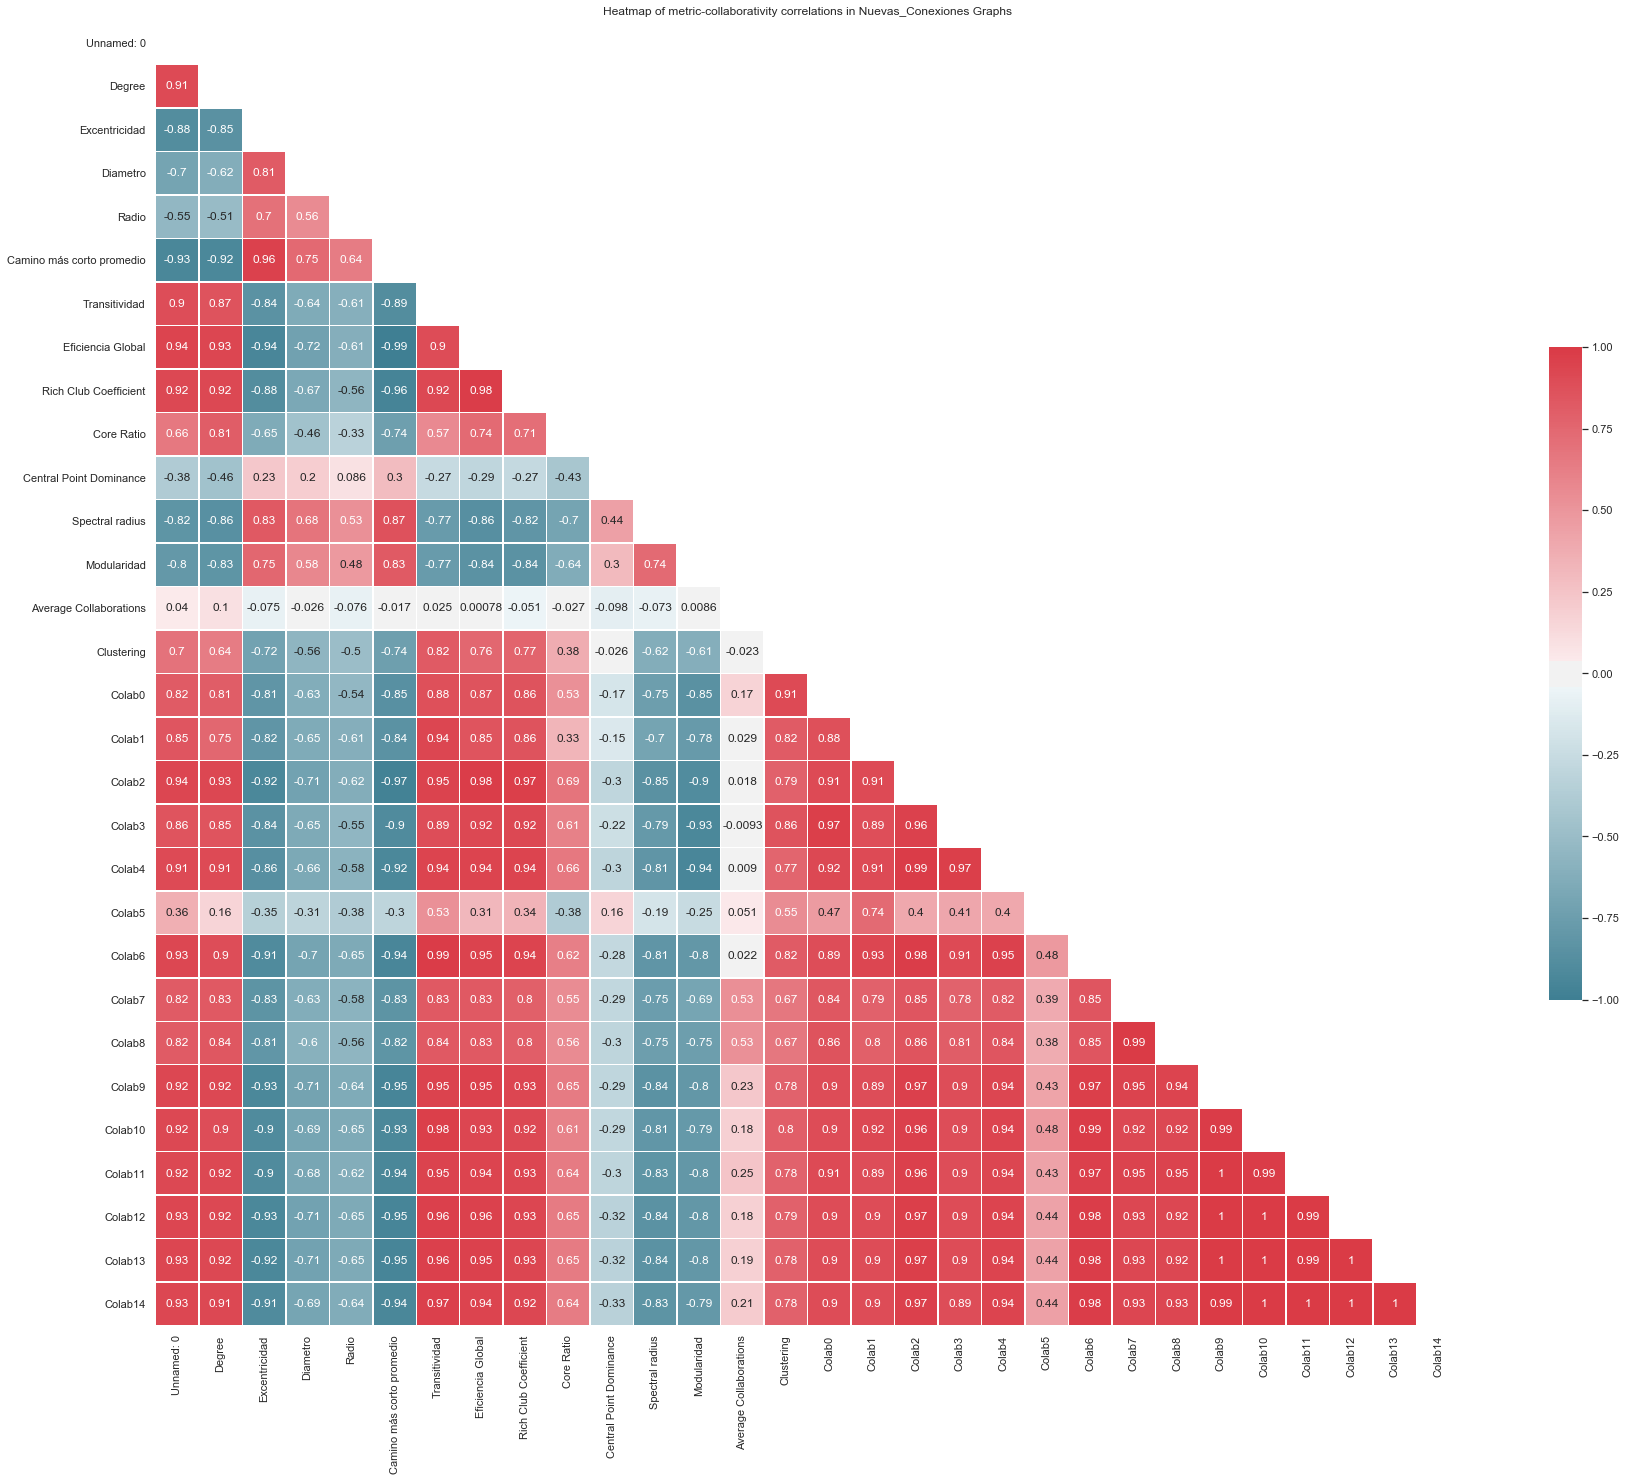

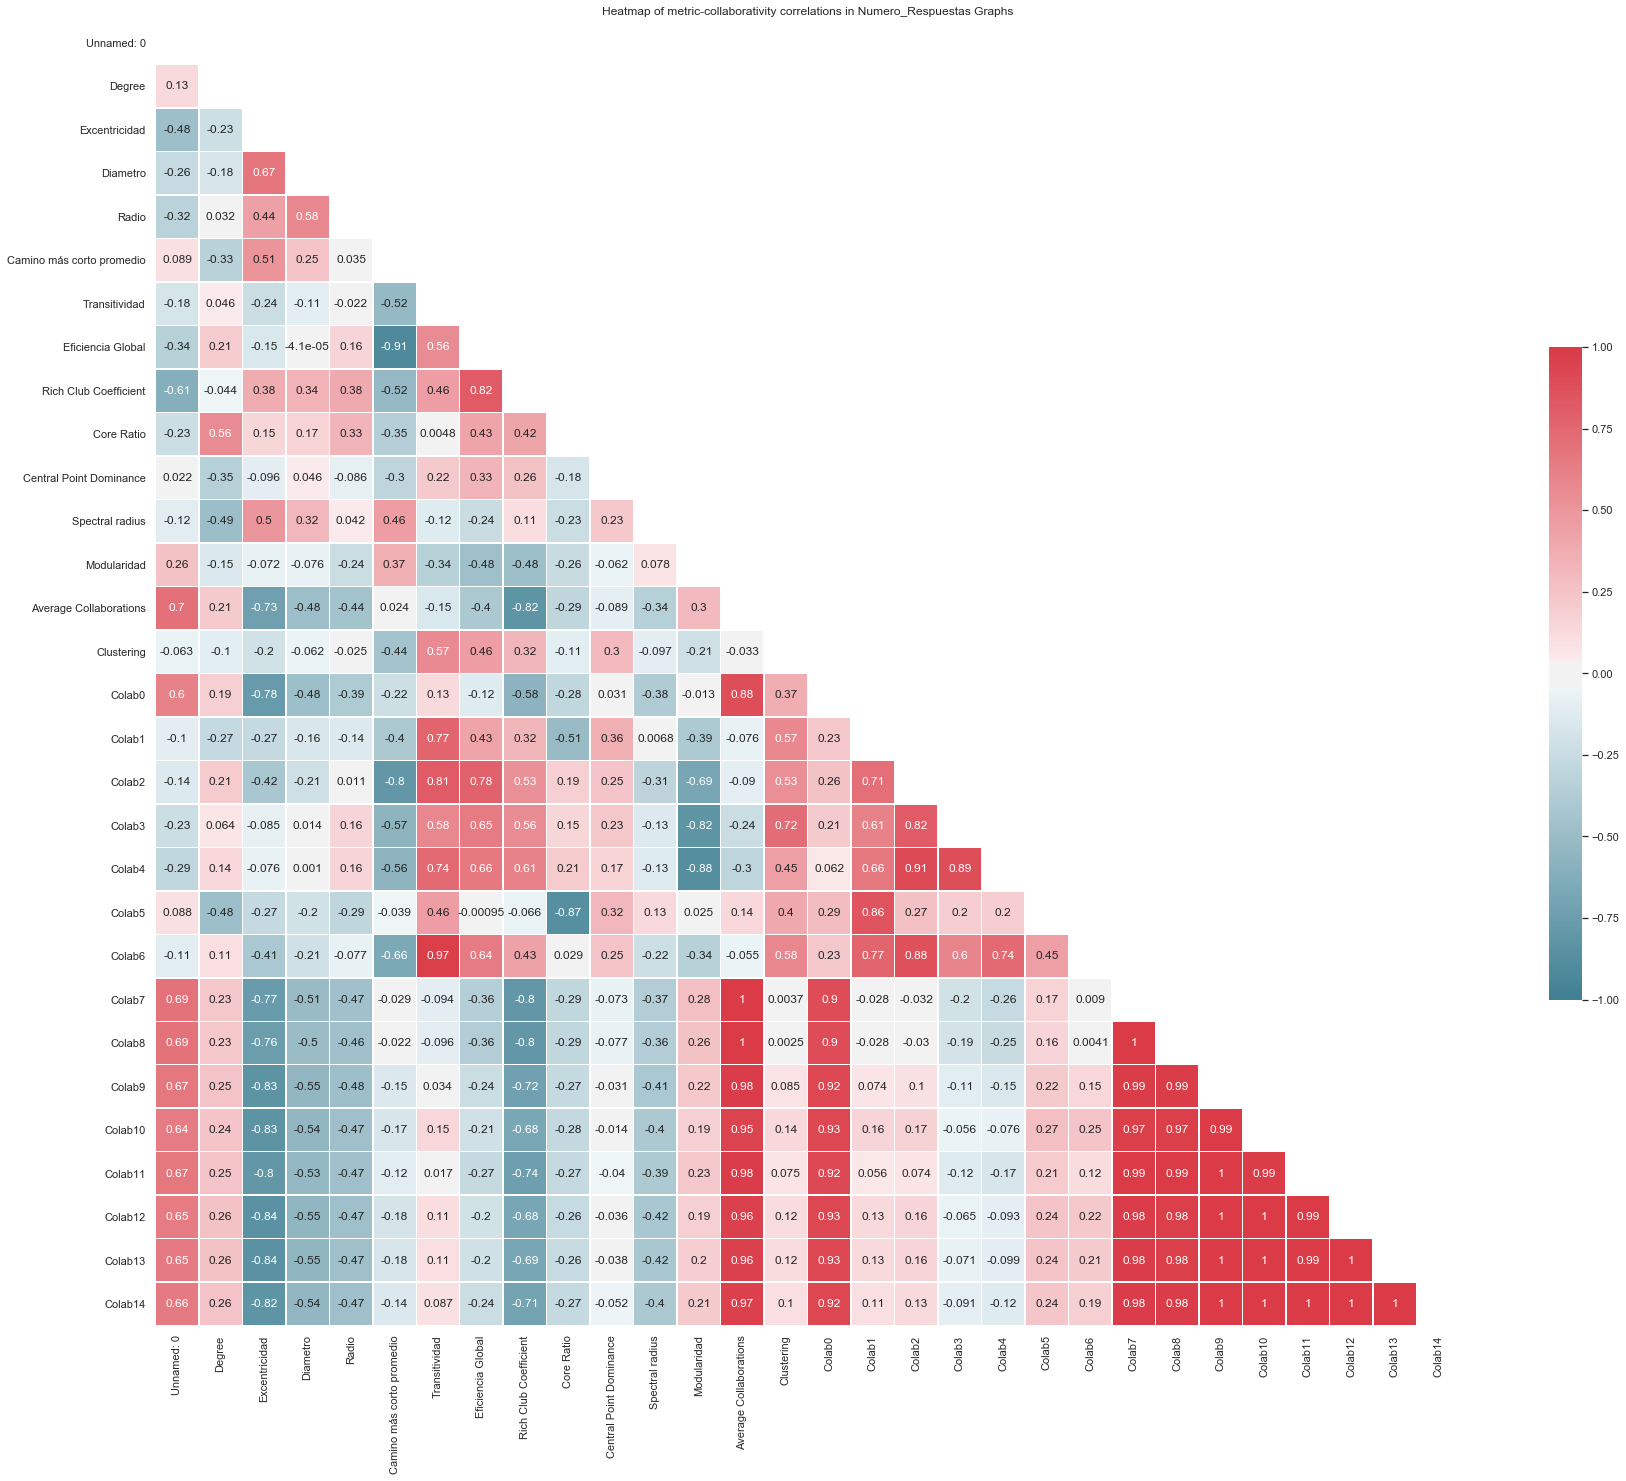

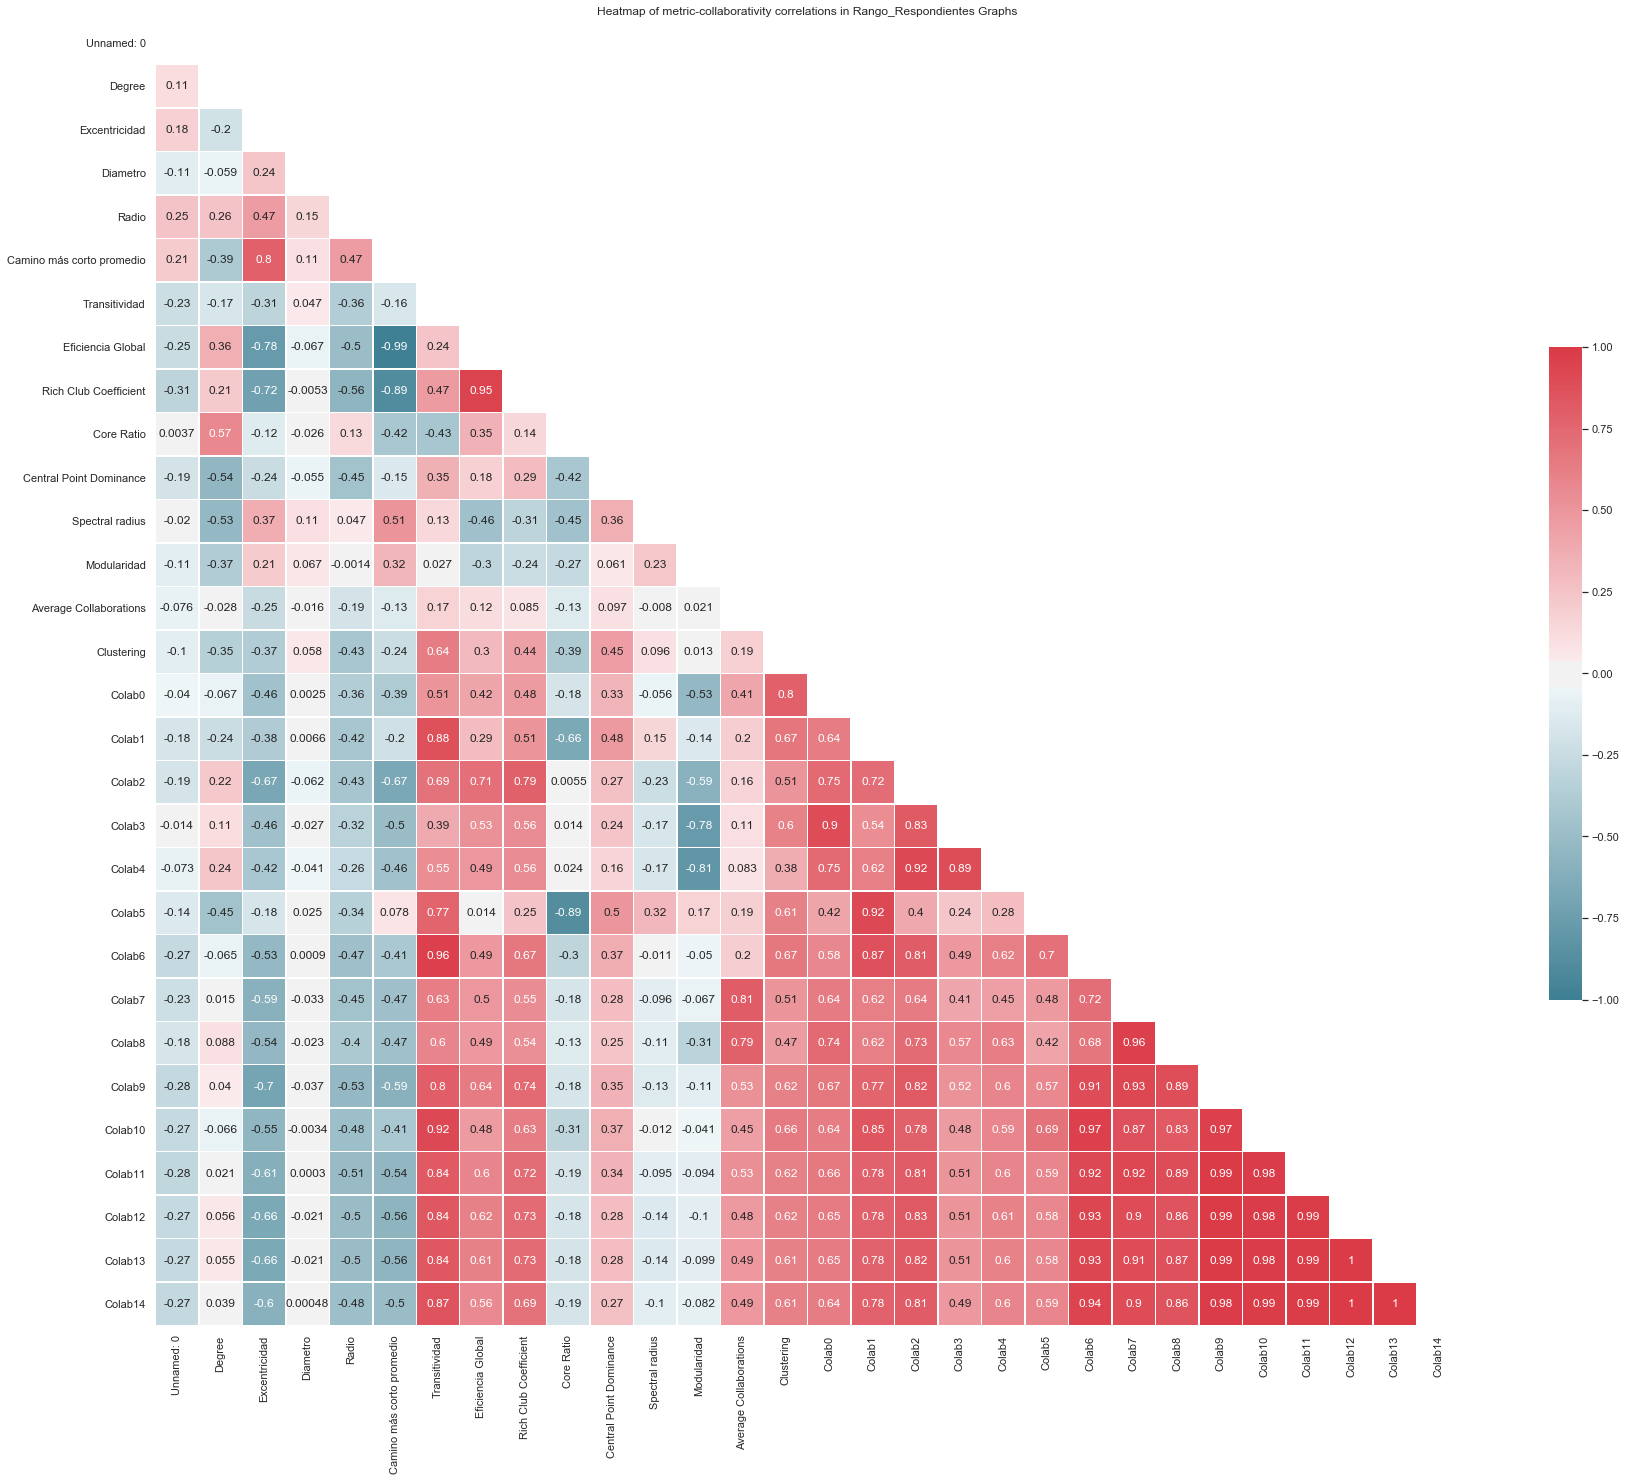

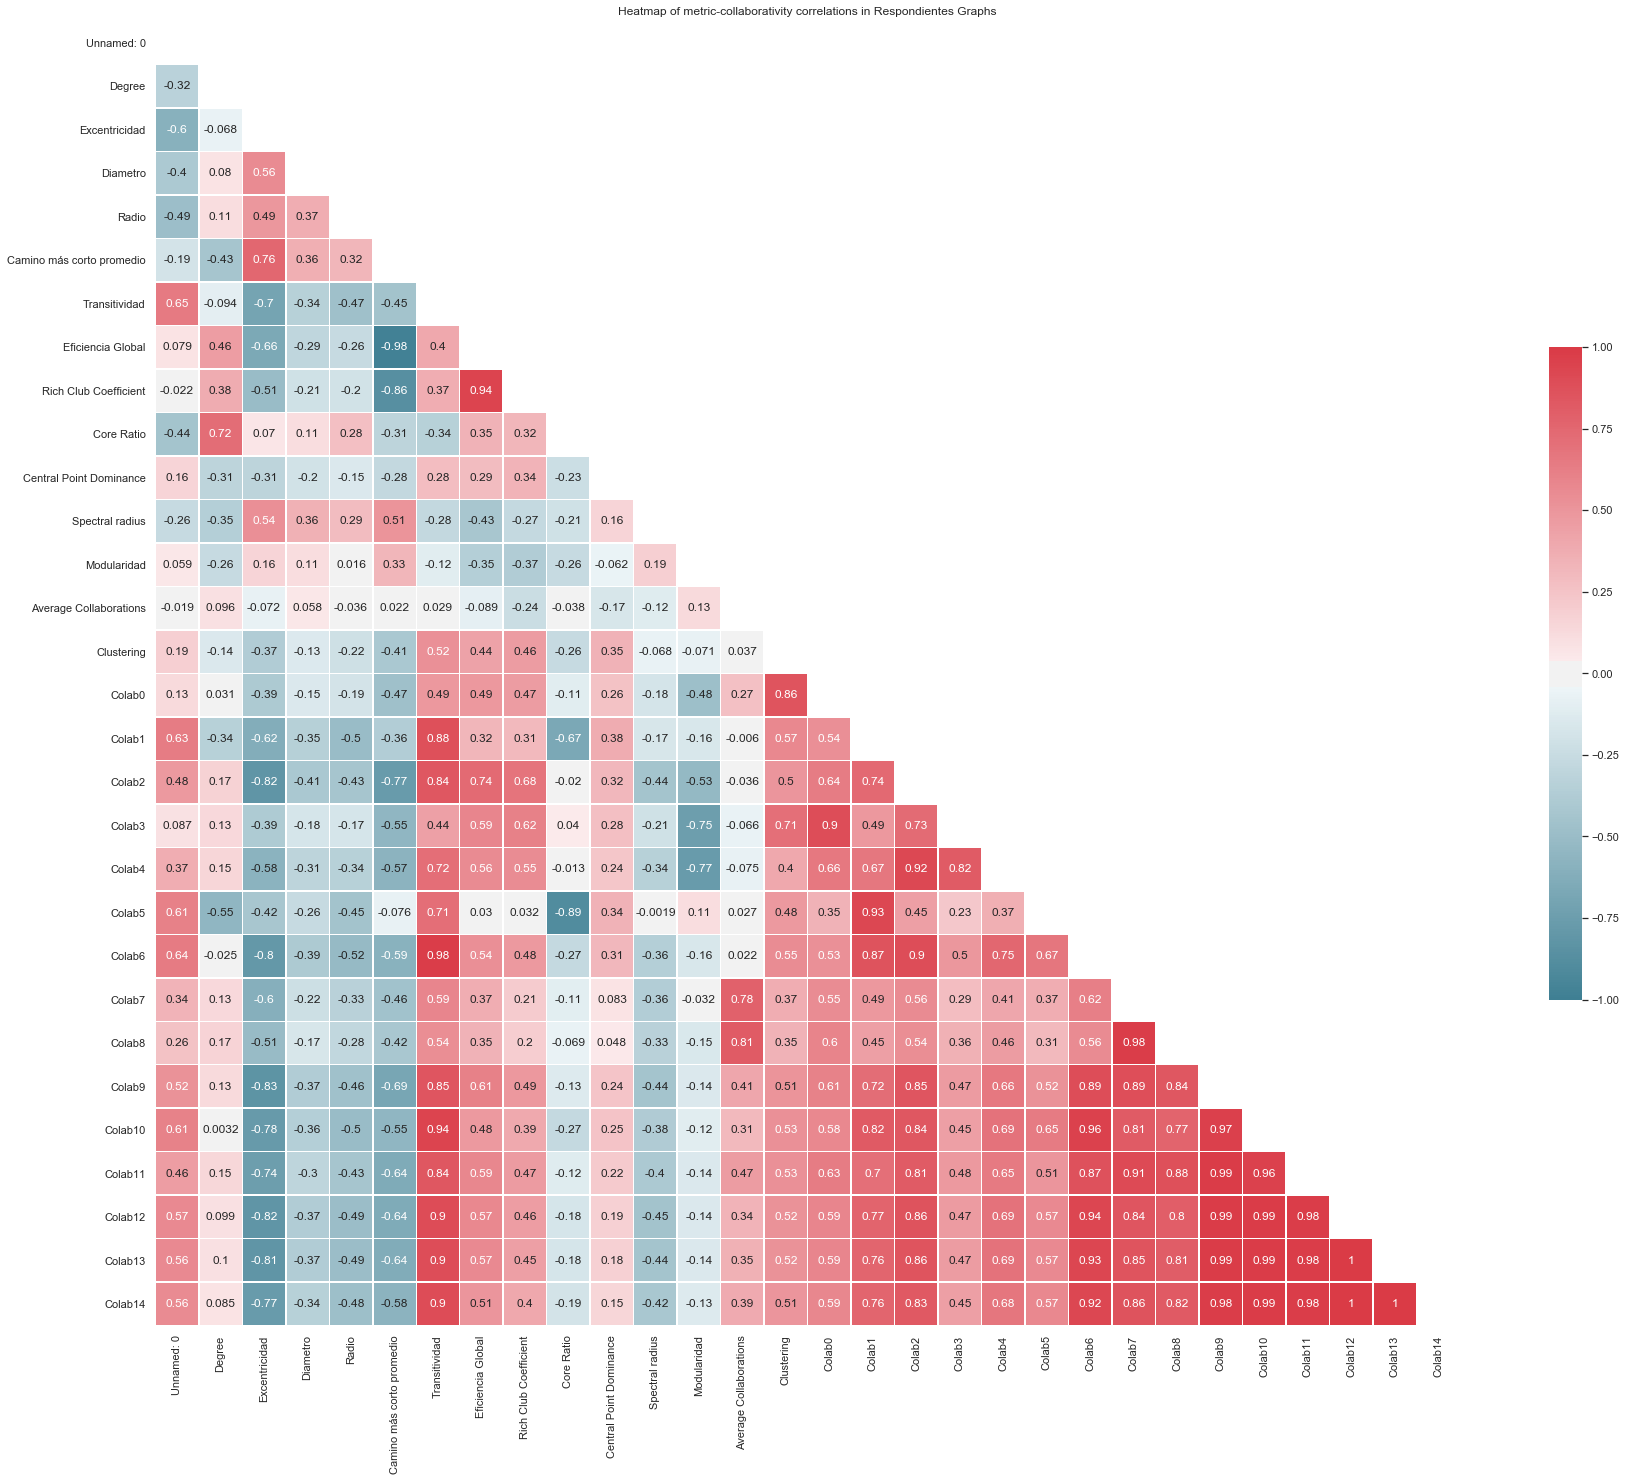

In [12]:
dfs_corr={}
for key in dfs.keys():
    for i in range(len(colaborativity_formulas)):
        dfs[key]["Colab"+str(i)]=colaborativity_formulas[i](dfs[key])
    dfs_corr[key]=dfs[key].corr()

sns.set(style="white")

for key in dfs.keys():
# Generate a mask for the upper triangle
    mask= np.triu(np.ones_like(dfs_corr[key], dtype=np.bool))

# Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(32, 24))

# Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dfs_corr[key], mask=mask, cmap=cmap, annot=True, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_title('Heatmap of metric-collaborativity correlations in '+ key + ' Graphs')